## Problem Statement: 

Dream Housing Finance company deals in all kinds of home loans. They have presence across all urban, semi urban and rural areas. Customer first applies for home loan and after that company validates the customer eligibility for loan.

Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have provided a dataset to identify the customers segments that are eligible for loan amount so that they can specifically target these customers. 

#### Variables and their descriptions

| Variable | Description |
|-|-|
| Loan_ID | Unique Loan ID |
| Gender | Male/ Female |
| Married | Applicant married (Y/N) |
| Dependents | Number of dependents |
| Education | Applicant Education (Graduate/ Under Graduate) |
| Self_Employed | Self employed (Y/N) |
| ApplicantIncome | Applicant income |
| CoapplicantIncome | Coapplicant income |
| LoanAmount | Loan amount in thousands |
| Loan_Amount_Term | Term of loan in months |
| Credit_History | credit history meets guidelines |
| Property_Area | Urban/ Semi Urban/ Rural |
| Loan_Status | (Target) Loan approved (Y/N) |

### Import Libraries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler 

import warnings
warnings.filterwarnings('ignore')

### Import Dataset

In [2]:
dataset = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

cat_vars = ['Gender', 'Married', 'Dependents', 'Education','Self_Employed','Credit_History', 'Property_Area']
text_vars = ['Loan_ID']
num_vars = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount','Loan_Amount_Term']

In [3]:
dataset.groupby("Loan_Status")["Loan_ID"].count()

Loan_Status
N    192
Y    422
Name: Loan_ID, dtype: int64

## Exploratory Data Analysis

### Identifying count of Missing Values

In [4]:
print(test.info())
test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
Loan_ID              367 non-null object
Gender               356 non-null object
Married              367 non-null object
Dependents           357 non-null object
Education            367 non-null object
Self_Employed        344 non-null object
ApplicantIncome      367 non-null int64
CoapplicantIncome    367 non-null int64
LoanAmount           362 non-null float64
Loan_Amount_Term     361 non-null float64
Credit_History       338 non-null float64
Property_Area        367 non-null object
dtypes: float64(3), int64(2), object(7)
memory usage: 34.5+ KB
None


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,367.000000,367.000000,362.000000,361.000000,338.000000
mean,4805.599455,1569.577657,136.132597,342.537396,0.825444
std,4910.685399,2334.232099,61.366652,65.156643,0.380150
min,0.000000,0.000000,28.000000,6.000000,0.000000
25%,2864.000000,0.000000,100.250000,360.000000,1.000000
50%,3786.000000,1025.000000,125.000000,360.000000,1.000000
75%,5060.000000,2430.500000,158.000000,360.000000,1.000000
max,72529.000000,24000.000000,550.000000,480.000000,1.000000


Text(0.5, 1.0, 'Percentage of Missing Values in each column')

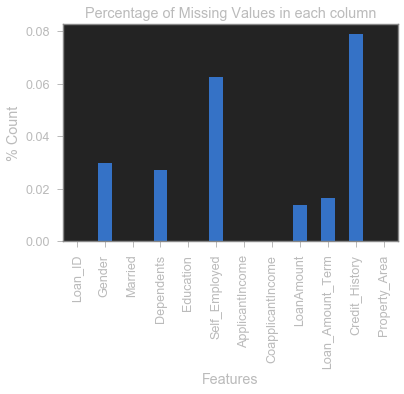

In [5]:
((test.isnull().sum())/len(test)).plot(kind ='bar')
plt.xlabel('Features')
plt.ylabel('% Count')
plt.title('Percentage of Missing Values in each column')

### Dealing with Missing Values

In [6]:
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer_median = SimpleImputer(missing_values=np.nan, strategy='median')
imputer_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

dataset['Loan_Amount_Term'] = imputer_mode.fit_transform(dataset[['Loan_Amount_Term']])
dataset['LoanAmount'] = imputer_mean.fit_transform(dataset[['LoanAmount']])
dataset['Gender'] = imputer_mode.fit_transform(dataset[['Gender']])
dataset['Dependents'] = imputer_mode.fit_transform(dataset[['Dependents']])
dataset['Self_Employed'] = imputer_mode.fit_transform(dataset[['Self_Employed']])
dataset['Credit_History'] = dataset[['Credit_History']].fillna("Unknown")

test['Loan_Amount_Term'] = imputer_mode.fit_transform(test[['Loan_Amount_Term']])
test['LoanAmount'] = imputer_mean.fit_transform(test[['LoanAmount']])
test['Gender'] = imputer_mode.fit_transform(test[['Gender']])
test['Dependents'] = imputer_mode.fit_transform(test[['Dependents']])
test['Self_Employed'] = imputer_mode.fit_transform(test[['Self_Employed']])
test['Credit_History'] = test[['Credit_History']].fillna("Unknown")

dataset,test = dataset.dropna(),test.dropna()

### Univariate Analysis

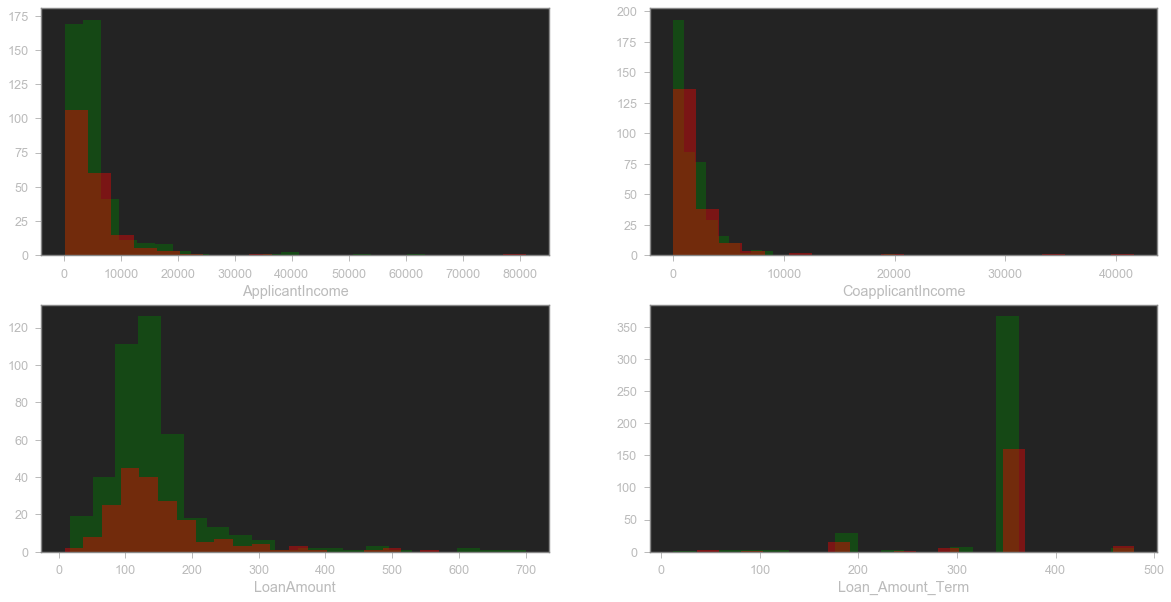

In [7]:
plt.figure(figsize= (20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    sns.distplot(dataset[dataset["Loan_Status"] == "Y"][num_vars[i]].dropna(), kde=False, bins = 20, color = "green")
    sns.distplot(dataset[dataset["Loan_Status"] == "N"][num_vars[i]].dropna(), kde=False, bins = 20, color = "red")

Applicant Income, Copplicant Income and Loan Amount is Normally Distributed with Left Skew implying presence of outliers in the data.

### Dealing with Outliers

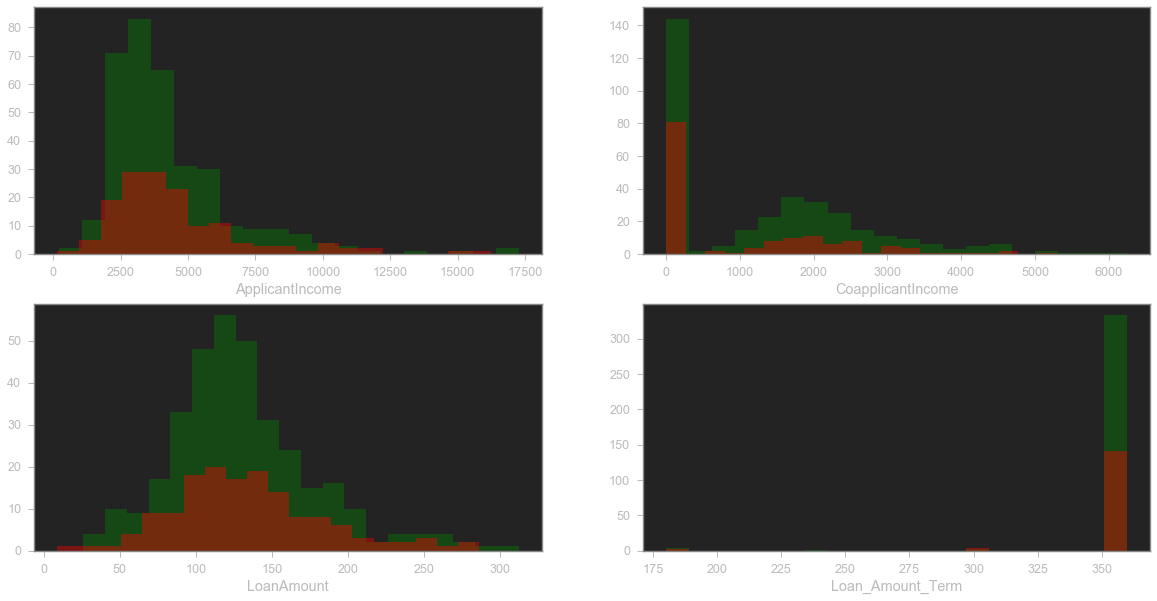

In [8]:
outlier_model = IsolationForest(contamination=0.2)
outlier_model.fit(dataset[num_vars])
dataset["outliers"] = outlier_model.predict(dataset[num_vars])
dataset = dataset[dataset["outliers"]==1]

plt.figure(figsize= (20,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    sns.distplot(dataset[dataset["Loan_Status"] == "Y"][num_vars[i]].dropna(), kde=False, bins = 20, color = "green")
    sns.distplot(dataset[dataset["Loan_Status"] == "N"][num_vars[i]].dropna(), kde=False, bins = 20, color = "red")

### Bivariate Analysis

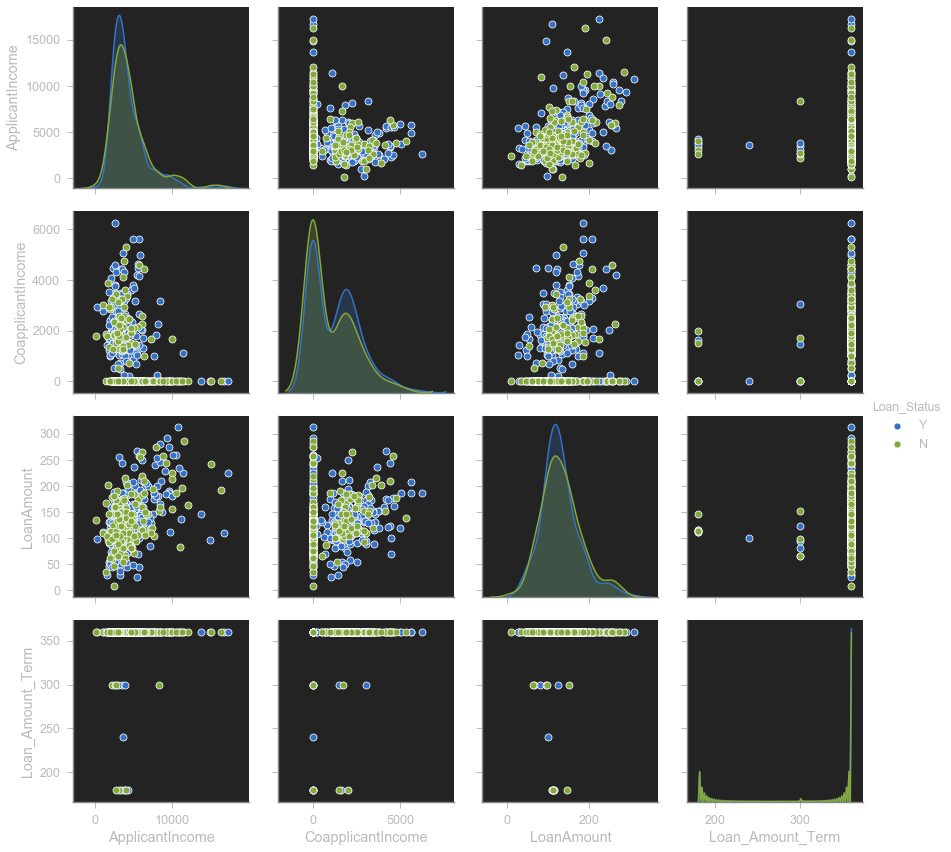

In [9]:
sns.pairplot(dataset, hue="Loan_Status",vars= num_vars, height= 3)

In [10]:
for i in cat_vars:
    print("\nValue Counts for " + str(i) + " is")
    print(dataset[i].value_counts(normalize= True))


Value Counts for Gender is
Male      0.803681
Female    0.196319
Name: Gender, dtype: float64

Value Counts for Married is
Yes    0.633947
No     0.366053
Name: Married, dtype: float64

Value Counts for Dependents is
0     0.611452
2     0.161554
1     0.159509
3+    0.067485
Name: Dependents, dtype: float64

Value Counts for Education is
Graduate        0.768916
Not Graduate    0.231084
Name: Education, dtype: float64

Value Counts for Self_Employed is
No     0.879346
Yes    0.120654
Name: Self_Employed, dtype: float64

Value Counts for Credit_History is
1.0        0.775051
0.0        0.145194
Unknown    0.079755
Name: Credit_History, dtype: float64

Value Counts for Property_Area is
Semiurban    0.390593
Urban        0.314928
Rural        0.294479
Name: Property_Area, dtype: float64


Gender  Loan_Status
Female  1              0.656250
        0              0.343750
Male    1              0.707379
        0              0.292621
Name: Loan_Status, dtype: float64
Married  Loan_Status
No       1              0.659218
         0              0.340782
Yes      1              0.719355
         0              0.280645
Name: Loan_Status, dtype: float64
Dependents  Loan_Status
0           1              0.698997
            0              0.301003
1           1              0.653846
            0              0.346154
2           1              0.734177
            0              0.265823
3+          1              0.696970
            0              0.303030
Name: Loan_Status, dtype: float64
Education     Loan_Status
Graduate      1              0.715426
              0              0.284574
Not Graduate  1              0.637168
              0              0.362832
Name: Loan_Status, dtype: float64
Self_Employed  Loan_Status
No             1              0.702326
       

<Figure size 1440x1440 with 0 Axes>

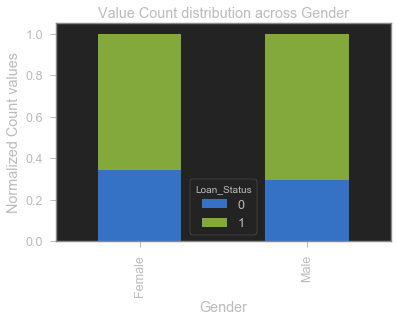

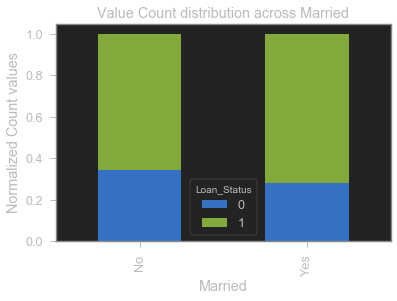

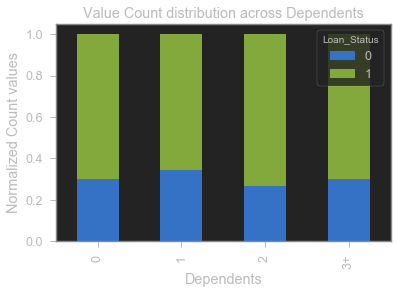

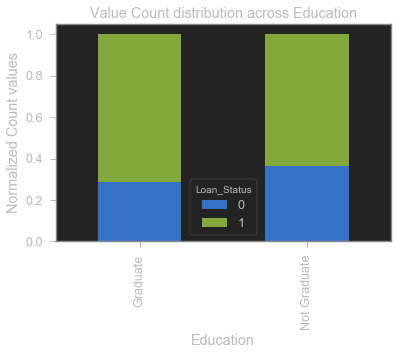

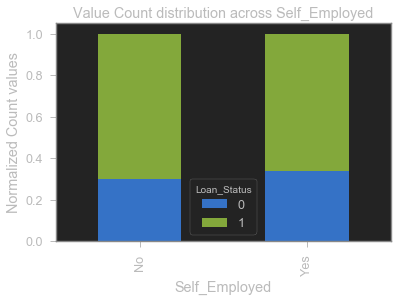

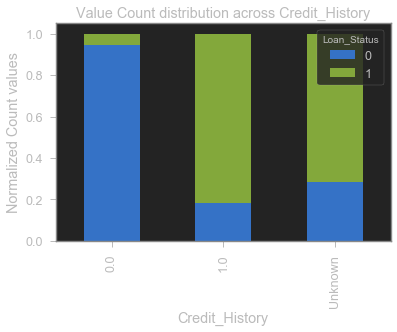

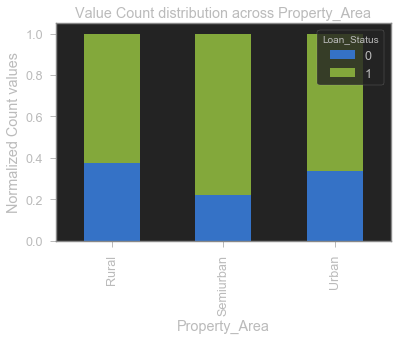

In [11]:
le = LabelEncoder()
dataset["Loan_Status"] = le.fit_transform(dataset["Loan_Status"])
plt.figure(figsize=(20,20))

for i in cat_vars:
    ax = dataset.groupby(i)["Loan_Status"].value_counts(normalize= True).unstack(level= 1).plot(kind= "bar" , stacked= True)
    ax.set_xlabel(i)
    ax.set_ylabel("Normalized Count values")
    ax.set_title("Value Count distribution across " + i)
    print(dataset.groupby(i)["Loan_Status"].value_counts(normalize= True))

### Conclusions

- Out of the total number of applicants for Loan Approval, 80% were Males of which 71% got the approval, and 20% were Females of which 66% got their Loans approved. 

- 63% of the total applicants were Married and 73% of them were able to get the approval, whereas off the 37% unmarried applicants only 66% of them were able to get the approval. 

- Most of the applicants had no dependents,comprising of 62% of population, off which 70% were able to get their loans approved. Amongst the different dependent count,applicants with '2' and '3+' were able to get their loans approved easily with convertion of 74% and 73% respectively. 

- 78% of the total applicants were Graduates off which 72% of them recieved the loans, of the rest 22% only 65% of them got their loans approved. Education seems to be an important parameter for loan approval.

- Only 12% of the applicants were Self Employed with 67% recieving the approval, off the rest 88% , 70% got their loans approved. 

- Out of the 78% with valid Credit History 82% of them managed to get their loans approved. 13% of the applicants had a bad credit history and hence, only 6% of them got their loans. Credit History is one of the important parameters for deciding the Loan Status

- Out of the total applicants 31% resided in Urban, 39% in Semi Urban and 29% in Rural households. Considering the Loan Status of the applicants, Semi Urban based applicants had the highest approval rates of 78% and Rural based applicants had the lowest with 63%.

In [12]:
new_data = pd.get_dummies(dataset,columns= cat_vars,drop_first= True)
new_test = pd.get_dummies(test,columns= cat_vars,drop_first= True)

output = new_data.pop("Loan_Status")
del new_data["outliers"]
new_data.insert(16,"Loan_Status",output)

X = new_data.iloc[:,1:-1]
Y = new_data.iloc[:,-1]
test = new_test.iloc[:,1:]

### Random Forest Classifier

In [13]:
model = RandomForestClassifier()
model.fit(X,Y)
Y_pred = model.predict(test)

solution_RFC = pd.DataFrame([])
solution_RFC["Loan_ID"] = new_test["Loan_ID"]
solution_RFC["Loan_Status"] = pd.DataFrame(le.inverse_transform(Y_pred))
solution_RFC["Loan_Status"].value_counts()

solution_RFC.to_csv("solution_RFC.csv",index= False)

### XGB Classifier

In [14]:
model = XGBClassifier()
model.fit(X,Y)
Y_pred = model.predict(test)

solution_XGB = pd.DataFrame([])
solution_XGB["Loan_ID"] = new_test["Loan_ID"]
solution_XGB["Loan_Status"] = pd.DataFrame(le.inverse_transform(Y_pred))
solution_XGB["Loan_Status"].value_counts()

solution_XGB.to_csv("solution_XGB.csv",index= False)

### Logistic Regression

In [21]:
ss = StandardScaler() 
X = ss.fit_transform(X)  
test = ss.transform(test)


model = LogisticRegression(random_state = 0) 
model.fit(X, Y) 
Y_pred = model.predict(test)

solution_LR = pd.DataFrame([])
solution_LR["Loan_ID"] = new_test["Loan_ID"]
solution_LR["Loan_Status"] = pd.DataFrame(le.inverse_transform(Y_pred))
solution_LR["Loan_Status"].value_counts()

solution_LR.to_csv("solution_LR.csv",index= False)